In [173]:
from utils.CoopEnv import CoopEnv
from utils.SGAgentk import GAgent

In [174]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [175]:
# Set constant hyperparameters
n = 30
num_of_tasks  = 15
num_of_sims = 5
step_limit = 20000

In [176]:
lower_bound = 0
upper_bound = 2.00
comm_array = np.linspace(lower_bound, upper_bound, 21)

comm_space = len(comm_array)

In [177]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [178]:
steps_to_complete = np.zeros((num_of_sims, step_limit))
comm_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
move_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
rec_rewards = np.zeros((num_of_sims, step_limit, env.n))

In [179]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        # reset the environment
        observations, locs = env.reset(n=n, num_of_tasks =num_of_tasks )
        #agentlist = {i: GAgent(num_tasks=num_of_tasks, start_task=locs[f'Player {i+1}'],  temperature_decay=temperature_decay) for i in range(env.n)}
        agentlist = {i: GAgent(num_tasks=num_of_tasks, start_task=locs[f'Player {i+1}']) for i in range(env.n)}
        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            # movement phase
            move_action = np.array([agentlist[i].choose_action_move() for i in range(env.n)])
            next_observations = env.step1(move_action)

            # communication phase
            comm_action = np.ones((env.n), dtype=int) # payoff should be distributed equally because all ask for max reward

            # reward distribution phase
            rewards = env.step2(comm_action) # env.step

            move_rec_actions[s, t, :] = move_action

            for i in range(env.n): # train each agent
                agentlist[i].update(rewards[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t] = sum(rewards)/env.n
            rec_rewards[s, t, :] = rewards


            # increment timestep and loop
            t +=1


In [180]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------
----------------------------------
Starting training simulation 1:
----------------------------------
----------------------------------
Starting training simulation 2:
----------------------------------
----------------------------------
Starting training simulation 3:
----------------------------------
----------------------------------
Starting training simulation 4:
----------------------------------


In [181]:
# save reward and actions
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

np.save(f'n{n}t{num_of_tasks}_cum_rew', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_rewards', rec_rewards)
np.save(f'n{n}t{num_of_tasks}_actions', comm_rec_actions)
np.save(f'n{n}t{num_of_tasks}_cstruct.npy', converged_structure)

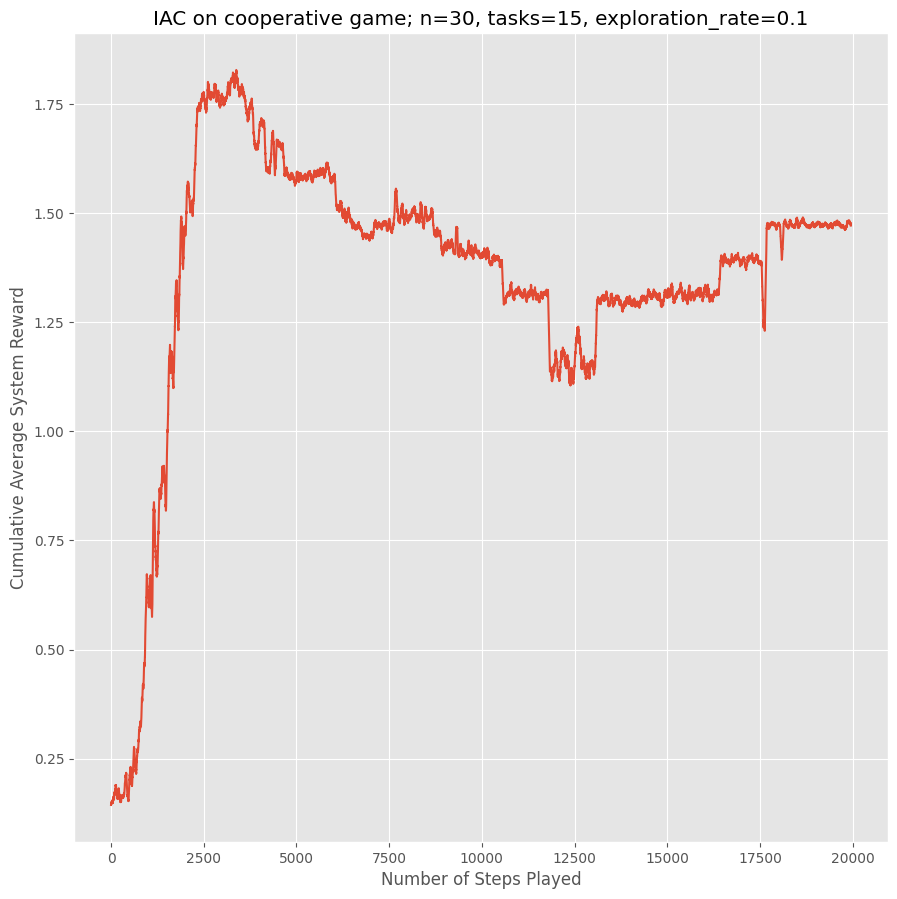

In [182]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)

def moving_average(arr, window_size):
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}, exploration_rate=0.1')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(moving_average(b,51))

[{'14'}, {'6'}, {'8'}, {'16'}, set(), set(), set(), {'12', '10', '9', '30', '13', '15', '25', '19', '3', '7', '26', '18', '23', '22', '27', '5', '21', '24', '4', '2', '17'}, set(), {'11'}, {'20'}, set(), {'28'}, {'1'}, {'29'}]


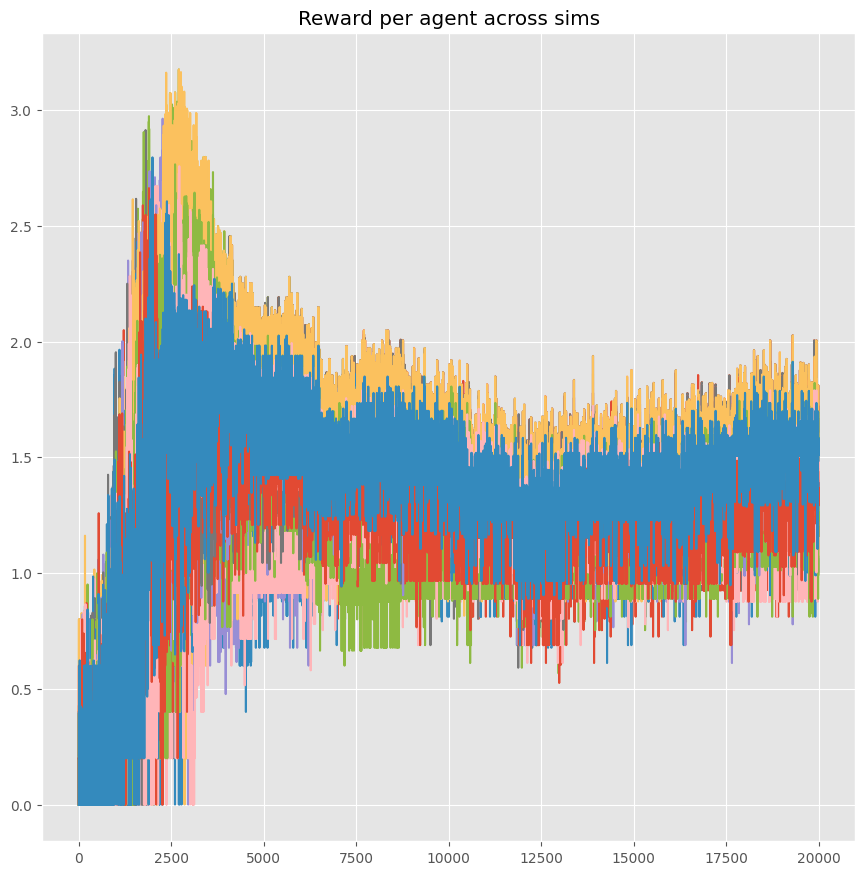

In [183]:
# see agent reward breakdown across sims

print(env.CS)
for j in range(env.n):
    col  = np.mean(rec_rewards[:,:,j],axis=0)
    plt.plot(moving_average(col, 1))

fig = plt.gcf()
plt.title('Reward per agent across sims')
fig.set_size_inches(10.5, 10.5)

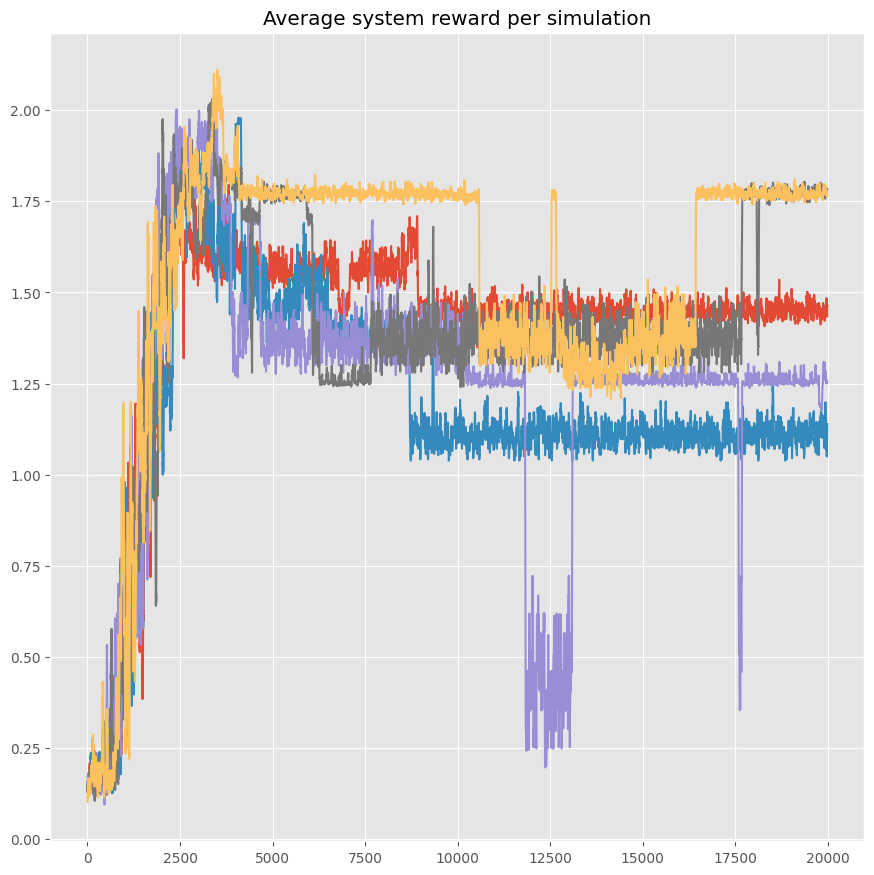

In [184]:
# See average reward breakdown for each sim

for i in range(num_of_sims):
    plt.plot(moving_average(steps_to_complete[i,:],20))

plt.title('Average system reward per simulation')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)